First off install dependencies. This assumes that the notebook is run in the correct virtualenv.

In [ ]:
!pip install pandas numpy seaborn gpy sklearn plotly

## Rename & Repackage Data
The data was in a format I did not prefer so it is renamed and repackaged here. This has to be done in several steps, else there is a memory error.

In [8]:
import pandas as pd
from math import radians, sin, cos

train_path = '../data/train3.pkl'
test_path = '../data/test3.pkl'

def equirectangular_projection(data):
    phi = data.lat.apply(radians)
    lamb = data.lon.apply(radians)
    lamb0 = lamb.mean()
    phi0 = phi.mean()
    r = 6378000  # earth radius in m
    x = r*(phi-phi0)
    y = r*(lamb - lamb0)*cos(phi0)
    return x, y

def compute_velocity(row):
    
    r = row.speed
    theta = radians(row.direction)
    row['dx'] = r*cos(radians(theta))
    row['dy'] = r*sin(radians(theta))
    return row

def filter_position_observed_events(data):
    return data[data.event == 'ObservedPositionEvent']

def repackage(from_path, to_path):
    data = pd.read_pickle(from_path)
    
    # Remove unnecessary fields
    del data['vehicle_id']
    del data['line']
    del data['station']
        
    data = filter_position_observed_events(data)
    
    del data['event']
    
    data.timestamp = data.timestamp.apply(pd.to_datetime)
    data = data.rename(columns = {
        'latitude': 'lat',
        'longitude': 'lon',
        'journey_number': 'traj',
        'segment_number': 'seg', 
        'speed': 'speed',
        'event': 'event',
        'timestamp': 'timestamp'
    })
    
    x, y = equirectangular_projection(data)
    data['x'] = x
    data['y'] = y
    
    del data['lat']
    del data['lon']

    data = data.apply(compute_velocity, axis=1)
    
    del data['direction']
    del data['speed']
    
    data.to_pickle(to_path)
    
repackage('../data/203_train.p', train_path)
repackage('../data/203_test.p', test_path)

KeyboardInterrupt: 

In [14]:
#data = pd.read_pickle('../data/train3.pkl')
#data.head()
def mean_timestamp(timestamps):    
    return pd.to_datetime(timestamps.values.astype(np.int64).mean())

X = data.iloc[0].copy()
data.iloc[4].timestamp = 6
X.timestamp = mean_timestamp(data.iloc[:10].timestamp)
compressed_data = data.drop(['timestamp', 'event', 'seg', 'station', 'line', 'traj'], axis=1).apply(np.mean, axis=0)
compressed_data['timestamp'] = mean_timestamp(data.iloc[:10].timestamp)# pd.Timestamp(2017, 1, 1, 12)
#compressed_data.timestamp = mean_timestamp(data.iloc[:10].timestamp)
compressed_data

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2018-02-16 03:48:40
2018-02-16 03:48:42.800000


Unnamed: 0                485.027
vehicle_id                5451.22
lon                       58.4093
lat                       15.5723
direction                  123.11
speed                      5.1206
timestamp     1518752922800000000
dtype: object

## Load training data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from IPython.display import display, clear_output
from model import learn_trajectory_model, plot_function, gamma_prior, FunctionModelPriors, TrajectoryModel
from predict import predict
from pandas import DataFrame
%load_ext autoreload
%autoreload 2

np.random.seed(1)
trajs_pickle_path = '../data/train3.pkl'
data = pd.read_pickle(trajs_pickle_path)
n_trajs = list(data.traj.unique())
n_trajs_to_use = 10 #len(n_trajs)
trajs_to_use = frozenset(np.random.choice(n_trajs, size=n_trajs_to_use, replace=False))
trajs = data[data.traj.transform(lambda j: j in trajs_to_use)]
traj_ns = trajs.traj.unique()
def load_seg(traj_n, seg_n):
    return trajs[(trajs.traj == traj_n) & (trajs.seg == seg_n)]

## Learn normalisation functions for each segment
All trajectories must be in the same space, so normalisation is done segement-wise. This will not be Euclidian, so ARD need to be used.

In [2]:
from segment_normaliser import normaliser_for_seg
seg_dict = dict(tuple(data.groupby('seg')))
seg_normalisers = {
    seg_n: normaliser_for_seg(seg_dict[seg_n])
    for seg_n in seg_dict
}

## Learn a model
Problem with velocity log likelihood becoming inf for fixed noise 0.004, but solved for 0.04. However, this gives all models a high likelihood, and shit performance.

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -220.11015802038293


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:119: RuntimeWarning:overflow encountered in expm1
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:121: RuntimeWarning:overflow encountered in expm1
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 2/3, f = -220.11015802038185
Optimization restart 3/3, f = -220.11015802038511
Optimization restart 1/3, f = -244.27830137838654
Optimization restart 2/3, f = -244.27830137793165
Optimization restart 3/3, f = -244.2783013784135
Optimization restart 1/3, f = 64.08271038012862
Optimization restart 2/3, f = 64.08271038012846
Optimization restart 3/3, f = 64.0827103801298
Optimization restart 1/3, f = 29.03465248970157
Optimization restart 2/3, f = 29.034652489800816
Optimization restart 3/3, f = 29.034652489676077


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Optimization restart 1/3, f = -3860.5086404788526
Optimization restart 2/3, f = -3860.508234264983
Optimization restart 3/3, f = -3860.5086404998683
Optimization restart 1/3, f = 333.56015001628367
Optimization restart 2/3, f = 333.57765526784004
Optimization restart 3/3, f = 333.5601500161235


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


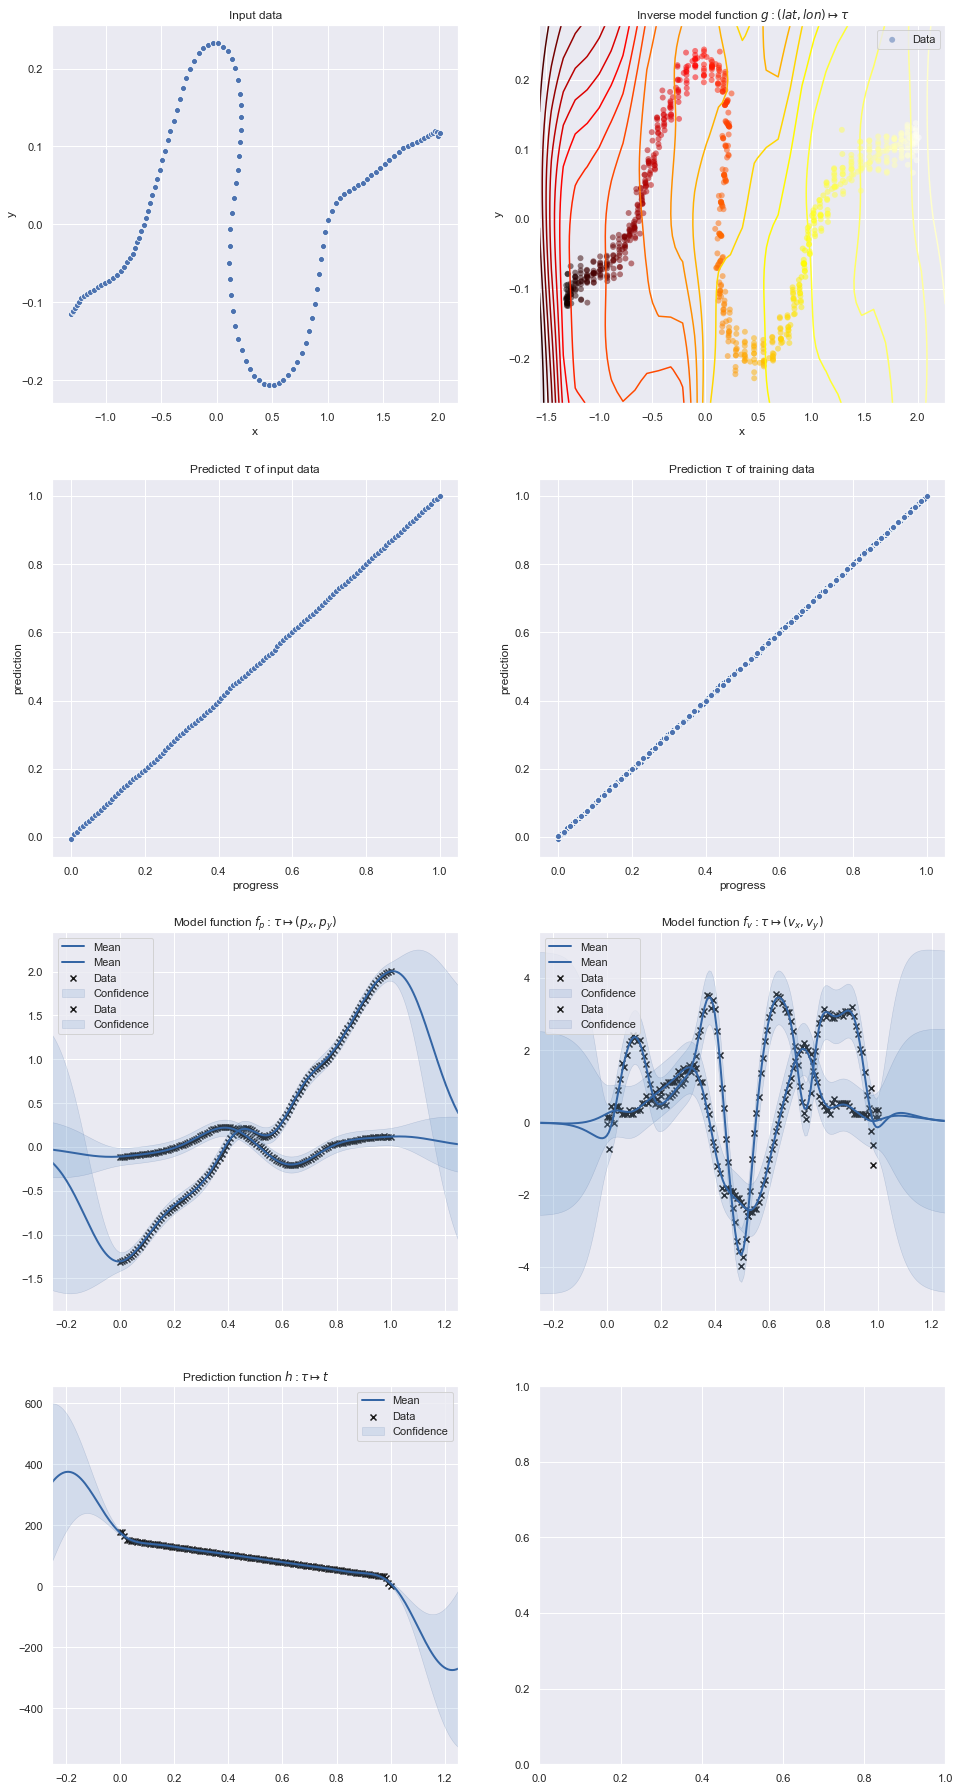

In [3]:
from math import sqrt, cos, sin, radians
from plotting import plot_grid
import seaborn as sns
import GPy
from GPy.models import GPRegression
from typing import List
from model import FunctionModel
from pre_process import pre_process
from learn import learn_model

%matplotlib inline
sns.set(style="darkgrid")

def plot_model(m: TrajectoryModel, data: DataFrame, f_p_codomain, f_v_codomain):
    n_rows = 4
    n_cols = 2
    fig_size = 8
    _, axs = plot_grid(n_rows, n_cols)

    # Input data
    sns.scatterplot(
        data=data, 
        x=f_p_codomain[0], 
        y=f_p_codomain[1], 
        ax=axs[0][0]
    )
    axs[0][0].set_title('Input data')

    # h for input data
    x = data[f_p_codomain].values
    mean, _  = predict(m.g, x)
    df = pd.DataFrame({
        'prediction': mean.T[0], 
        'progress': data['tau'].values
    })
    sns.scatterplot(
        data=df, 
        x='progress', 
        y='prediction', 
        ax=axs[1][0]
    )
    axs[1][0].set_title(r'Predicted $\tau$ of input data')
    #axs[1][0].set_aspect('equal', 'datalim')

    # Training data
    plot_function(m.g, ax=axs[0][1])
    axs[0][1].set_title(r'Inverse model function $g: (lat,lon) \mapsto \tau$')
    axs[0][1].set_xlabel('x')
    axs[0][1].set_ylabel('y')
    #axs[0][1].axis('scaled')
    
    # H for training data
    mean, _  = m.g.model.predict(m.g.model.X)
    df = pd.DataFrame({
        'prediction': mean.T[0], 
        'progress': m.g.model.Y.flatten()
    })
    sns.scatterplot(
        data=df, 
        x='progress', 
        y='prediction', 
        ax=axs[1][1]
    )
    axs[1][1].set_title(r'Prediction $\tau$ of training data')

    # f_p
    plot_function(m.f_p_x, ax=axs[2][0])
    plot_function(m.f_p_y, ax=axs[2][0])
    axs[2][0].set_title(r'Model function $f_p: \tau \mapsto (p_x, p_y)$')
    
    # f_v
    plot_function(m.f_v_x, ax=axs[2][1])
    plot_function(m.f_v_y, ax=axs[2][1])
    axs[2][1].set_title(r'Model function $f_v: \tau \mapsto (v_x, v_y)$')

    # h
    plot_function(m.h, ax=axs[3][0])
    axs[3][0].set_title(r'Prediction function $h: \tau \mapsto t$')

np.random.seed(1)
route_n = 3
seg_n = 9
train_traj_ix = 8
traj_n = traj_ns[train_traj_ix]
stop_compress_delta = 4  # meters   
f_p_likelihood_noise = 1 # meters  
f_v_likelihood_noise = .5  # m/s
seg = pre_process(
    load_seg(traj_n, seg_n),
    stop_compress_delta,
    seg_normalisers[seg_n]
)

f_p_codomain = ['x', 'y']
f_v_codomain = ['dx', 'dy']
m = learn_model(
    seg, route_n, seg_n, 
    f_p_codomain, f_v_codomain,
    f_p_likelihood_noise,
    f_v_likelihood_noise,
    seg_normalisers
)
plot_model(
    m, seg, 
    f_p_codomain, 
    f_v_codomain
)

## Learn many models

In [23]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import FunctionModelPriors, learn_trajectory_model, save_model, acquire_db_conn#plot_function, gamma_prior, , predict
from functools import reduce

np.random.seed(1)

def learn(traj_n, seg_n):
    seg = pre_process(
        load_seg(traj_n, seg_n), 
        stop_compress_delta, 
        seg_normalisers[seg_n]
    )
    return learn_model(
        seg, route_n, seg_n, 
        f_p_codomain, f_v_codomain,
        f_p_likelihood_noise, 
        f_v_likelihood_noise,
        seg_normalisers
    )

models = [
    learn(traj_n, seg_n) 
    for traj_n in traj_ns
]

with acquire_db_conn() as conn:
    for m in models:
        m_id = save_model(m, conn)

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -235.28205236511621
Optimization restart 2/3, f = -235.28205236511866
Optimization restart 3/3, f = -235.28205236302568


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -256.785341596276
Optimization restart 2/3, f = -256.785341596133
Optimization restart 3/3, f = -256.7853415964882
Optimization restart 1/3, f = 61.4109564969495
Optimization restart 2/3, f = 61.41095649694867
Optimization restart 3/3, f = 61.410956496948664
Optimization restart 1/3, f = 30.619705067219208
Optimization restart 2/3, f = 30.61970506721914
Optimization restart 3/3, f = 30.619705067218842
Optimization restart 1/3, f = -3402.707634784112
Optimization restart 2/3, f = -3402.7076443859323
Optimization restart 3/3, f = -3402.7076389303083
Optimization restart 1/3, f = 276.58720110513616
Optimization restart 2/3, f = 276.58720078184865
Optimization restart 3/3, f = 276.5872005556945


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -210.22303263736305
Optimization restart 2/3, f = -210.22303263736322
Optimization restart 3/3, f = -210.22303263723475


reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance


Optimization restart 1/3, f = -229.44948738131555
Optimization restart 2/3, f = -229.44948738131697
Optimization restart 3/3, f = -229.44948738131674
Optimization restart 1/3, f = 61.32447015596857
Optimization restart 2/3, f = 61.324470161912075
Optimization restart 3/3, f = 61.324470145621525
Optimization restart 1/3, f = 32.83661867300219
Optimization restart 2/3, f = 32.836618672878906
Optimization restart 3/3, f = 32.836618672900386
KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

## Load many models

In [4]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from model import FunctionModel, TrajectoryModel, acquire_db_conn, load_models
from typing import List, Tuple
from numpy import ndarray

conn = acquire_db_conn()
with conn:
    models = load_models(route_n, seg_n, conn)

'loaded {} models'.format(len(models))

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


'loaded 10 models'

# Make predictions

In [62]:
from functools import reduce
from scipy.stats import norm
from collections import defaultdict
from numpy.linalg import inv, det
import math
from plotting import plot_grid
from predict import  model_data_loglik, normalise_logliks, mixture_distributions

def model_observations_loglik(model: TrajectoryModel, X_obs: ndarray, tau: ndarray):
    return np.array([
        model_data_loglik(
            model, 
            np.array(x).reshape(1, -1), 
            tau.reshape(-1, 1)
        )
        for x, tau in zip(X_obs, tau)
    ]).reshape(-1, 1)

def model_data_loglik(model, X_obs, tau):
    def loglik(x: ndarray, mu: ndarray, sigma: ndarray):
        """Assumes sigma is the diagonal of the covariance matrix."""
        z = x-mu
        #print(np.hstack([x,mu,sigma]))
        #print(sigma, -0.5*np.log(np.prod(sigma)))
        return -0.5*z*(1/sigma)*z \
            -0.5*np.log(np.prod(sigma))

    pos = X_obs[:,0:2]
    vel = X_obs[:,2:4]
    X_k_p_x, sigma_p_x = predict(model.f_p_x, tau)
    X_k_p_y, sigma_p_y = predict(model.f_p_y, tau)
    X_k_v_x, sigma_v_x = predict(model.f_v_x, tau)
    X_k_v_y, sigma_v_y = predict(model.f_v_y, tau)
    
    loglik_pos_x = loglik(pos[:,0].reshape(-1, 1), X_k_p_x, sigma_p_x)
    loglik_pos_y = loglik(pos[:,1].reshape(-1, 1), X_k_p_y, sigma_p_y)
    loglik_vel_x = loglik(vel[:,0].reshape(-1, 1), X_k_v_x, sigma_v_x)
    loglik_vel_y = loglik(vel[:,1].reshape(-1, 1), X_k_v_y, sigma_v_y)
    model_loglik = \
        loglik_pos_x + \
        loglik_pos_y + \
        loglik_vel_x + \
        loglik_vel_y

    if math.isinf(model_loglik) or math.isnan(model_loglik):
        print('inf loglik')
    
    return model_loglik

def normalise_logliks(logliks):
    # Scale to avoid numerical errors due to small numbers
    return logliks - np.sum(logliks)

def to_probs(logliks):
    unnorm_probs = np.exp(logliks - np.max(logliks))
    return unnorm_probs / np.sum(unnorm_probs)

def model_weights(models_to_use, tau_mus):
    model_logliks = np.hstack([
        model_observations_loglik(m, X_obs, tau)
        for m, tau in zip(models_to_use, tau_mus)
    ])

    model_probs = np.apply_along_axis(to_probs, 1, model_logliks)
    cum_model_probs = np.apply_along_axis(np.cumsum, 0, model_probs)
    
    D = cum_model_probs.shape[1]
    model_prob_columns = [
        model_probs[:,i]
        for i in range(D)
    ]

    normalised_cum_model_probs = np.apply_along_axis(lambda row: row / np.sum(row), 1, cum_model_probs)
    cum_model_probs_columns = [
        normalised_cum_model_probs[:,i]
        for i in range(D)
    ]

    weights = np.apply_along_axis(lambda col: col[-1], 1, cum_model_probs_columns)

    return weights, model_prob_columns, cum_model_probs_columns

models_to_use = models
# Test on previously seen segment
test_traj_ix = 1
test_traj_id = traj_ns[test_traj_ix]
print('predicting for', test_traj_id)
fraction_observed = .5
seg = pre_process(
    load_seg(test_traj_id, seg_n), 
    stop_compress_delta, 
    seg_normalisers[seg_n],
    fraction_observed
)

time_left = seg.iloc[-1].time_left
f_codomain = ['x', 'y', 'dx', 'dy']
X_obs = seg[f_codomain].values
pos = X_obs[:,0:2]
current_tau = seg.iloc[-1].tau.reshape(-1, 1)

tau_mus = [predict(m.g, pos)[0] for m in models_to_use]
t_mus, t_sigmas = zip(*[predict(m.h, current_tau) for m in models_to_use])
t_mus = np.vstack(t_mus)
t_sigmas = np.vstack(t_sigmas)

weights, model_prob_columns, cum_model_probs_columns = model_weights(models_to_use, tau_mus)
posterior_components, t_grid = mixture_distributions(
    t_mus, t_sigmas, weights
)

predicting for 1278


## Plot Results

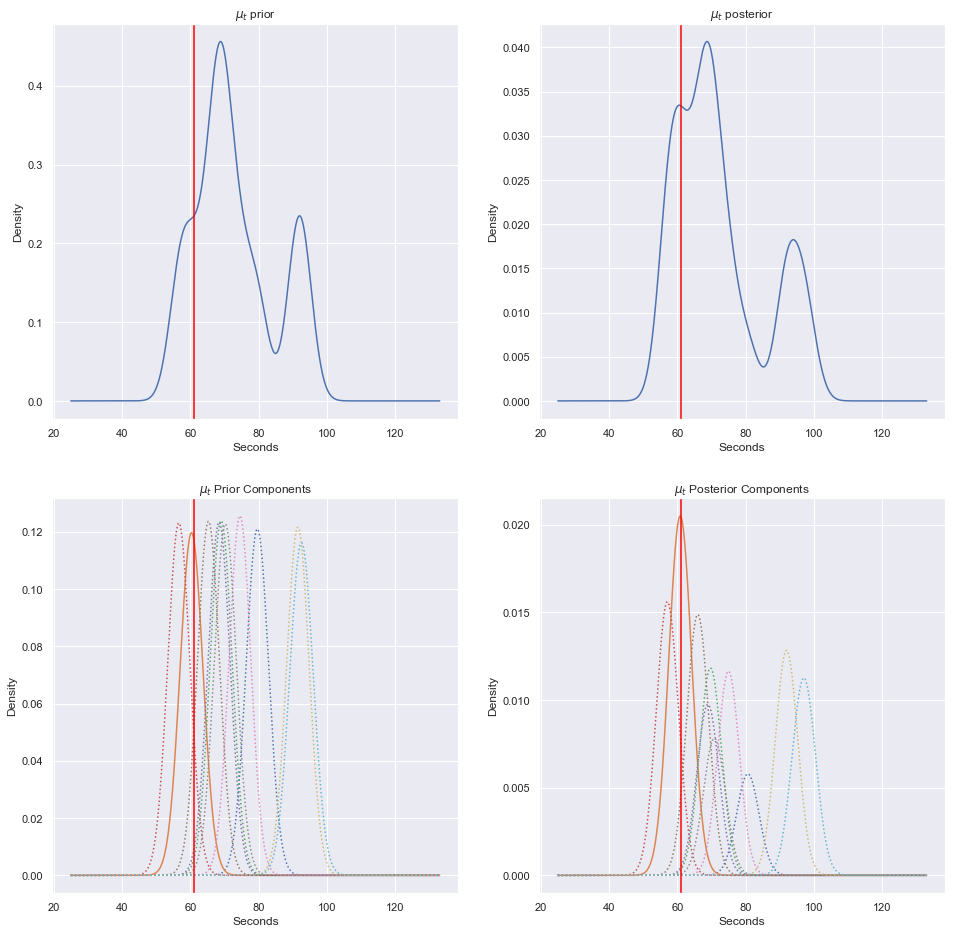

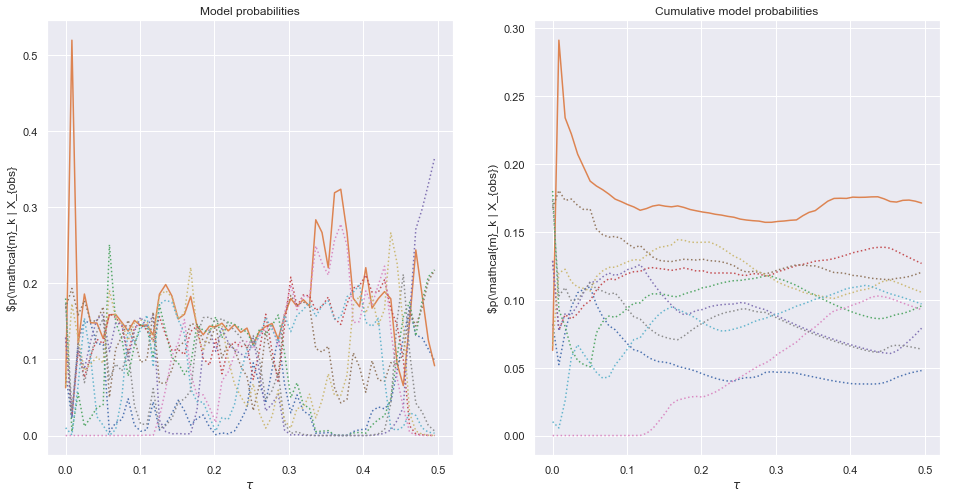

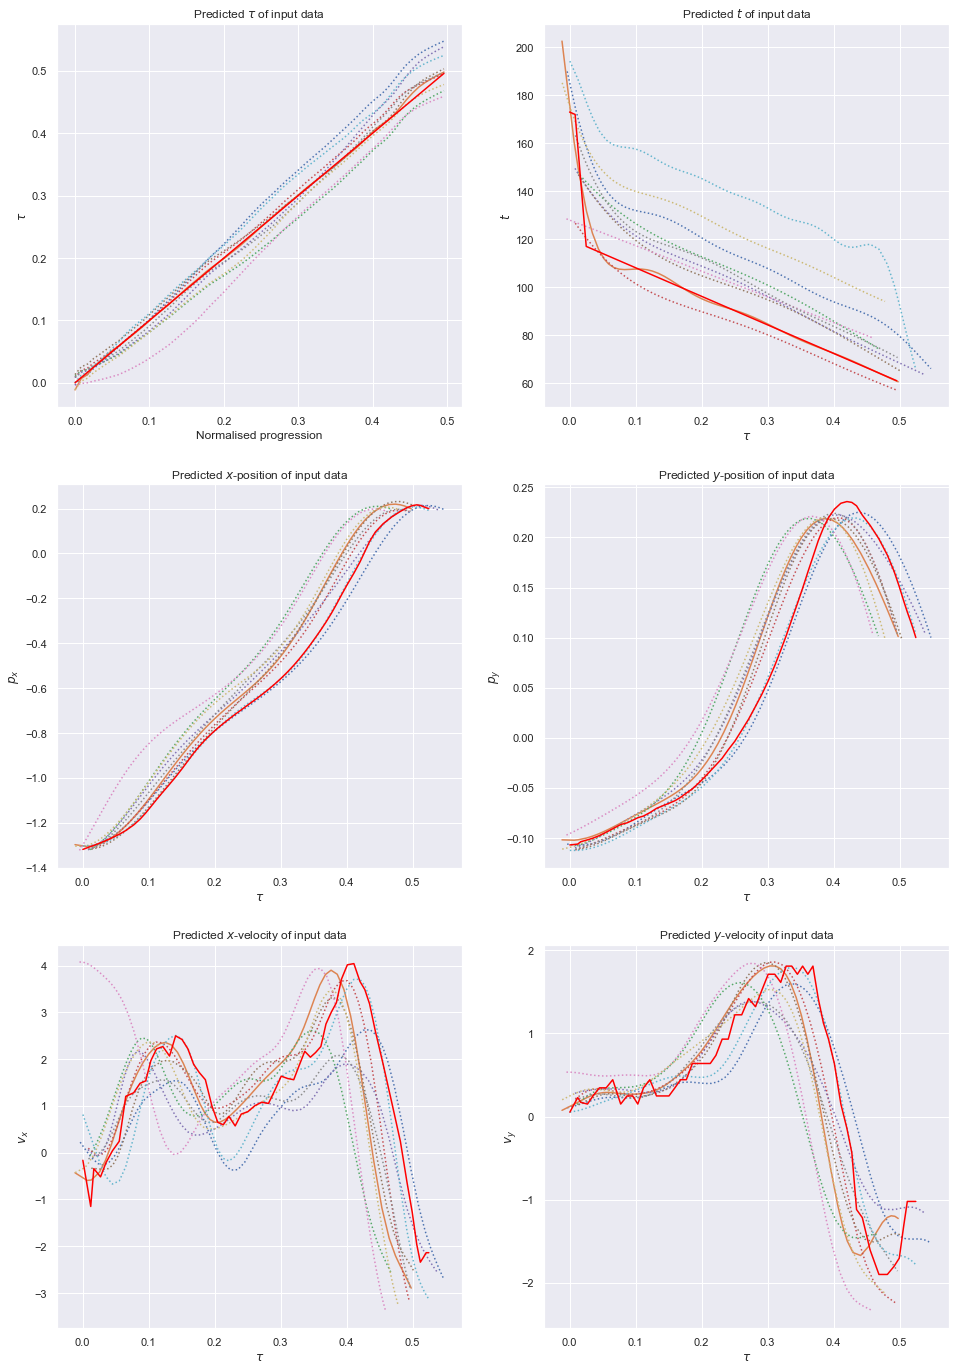

In [70]:
from predict import model_cum_loglik, prediction_distribution
from plotting import plot_grid, plot_mu_t, plot_model_probabilities, plot_state_model_means

linestyle = lambda i: '-' if i == test_traj_ix else ':'

cum_log_liks = [
    model_cum_loglik(m, X_obs, tau)
    for m, tau in zip(models_to_use, tau_mus)
]

prior_tau = np.array(fraction_observed).reshape(1, -1)
prior_components = [
    prediction_distribution(t_grid, predict(model.h, prior_tau))
    for model in models_to_use
]
plot_mu_t(
    t_grid, 
    prior_components, 
    posterior_components, 
    time_left, 
    linestyle
)

progression = np.linspace(
    0, seg.iloc[-1].tau, seg.shape[0]
).reshape(-1, 1)

plot_model_probabilities(
    progression, 
    model_prob_columns, 
    cum_model_probs_columns,
    linestyle
)

plot_state_model_means(
    models_to_use,
    seg,
    progression,
    linestyle
)

# Performance

In [60]:
from itertools import product
import numpy as np
from sklearn.linear_model import LinearRegression

def take_fraction(data, frac):
    r = int(data.shape[0]*frac)
    return data.head(r)

def compute_errors(pred, truth):
    abs_diff = np.abs(truth-pred)
    mae = abs_diff
    mape =  abs_diff / truth
    return mae, mape

def model_prediction(models, seg):
    pos = seg[f_codomain].values.reshape(-1, 2)
    current_tau = seg.iloc[-1].tau.reshape(1, -1)
    tau_mus = [
        predict(m.g, pos)[0]
        for m in models_to_use
    ]

    t_mus, t_sigmas = zip(*[
        predict(m.h, current_tau)
        for m in models_to_use
    ])

    weights, model_prob_columns, cum_model_probs_columns = model_weights(models_to_use, tau_mus)
    distributions, t_grid = mixture_distributions(
        t_mus, t_sigmas, weights
    )
 
    dist = reduce(np.add, distributions).reshape(t_grid.shape[0])
    pred = np.sum(dist * t_grid) / np.sum(dist) # mean
    #pred = xx[np.argmax(dist)] #mode
    #if math.isnan(pred):
    #    print('dists are nan for ', seg_size, test_seg_n)
        #print(dists)
    return pred

    #models_avg_mae = [np.sum(list(mae[s].values())) / len(mae[s].values()) for s in seg_sizes]
    #models_avg_mape = [np.sum(list(mape[s].values())) / len(mape[s].values()) for s in seg_sizes]
    #return models_avg_mae, models_avg_mape
    
def mean_prediction(seg):
    X = seg.tau.values.reshape(-1, 1)
    y = seg.time_left.values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    x_star = seg.iloc[-1].tau.reshape(-1, 1)
    return reg.predict(x_star)

def average_performance(performance, model):
    seg_sizes = list(performance.keys())
    seg_ns = list(performance[seg_sizes[0]].keys())
    return [np.sum([performance[seg_size][seg_n][model] for seg_n in seg_ns]) 
        for seg_size in seg_sizes
    ]

def evaluate(models, test_segs):
    maes  = {s: defaultdict(dict) for s in seg_sizes}
    mapes = {s: defaultdict(dict) for s in seg_sizes}
    for i, test_seg_n in enumerate(test_segs.keys()):
        for seg_size in test_segs[test_seg_n]:
            maes[seg_size][test_seg_n] = defaultdict(dict)
            mapes[seg_size][test_seg_n] = defaultdict(dict)
            
            seg = take_fraction(test_segs[test_seg_n], seg_size)
            time_left = seg.iloc[-1].time_left
            
            # Model performance
            model_pred = model_prediction(models, seg)
            model_mae, model_mape = compute_errors(model_pred, time_left)
            maes[seg_size][test_seg_n]['model'] = model_mae
            mapes[seg_size][test_seg_n]['model'] = model_mape
            
            # Mean prediction performance
            #mean_pred = mean_prediction(seg)
            #mean_mae, mean_mape = compute_errors(mean_pred, time_left)
            #maes[seg_size][test_seg_n]['mean'] = mean_mae
            #mapes[seg_size][test_seg_n]['mean'] = mean_mape
            
        #clear_output()
        print('Done seg', i, 'of', len(test_segs))
  
    model_avg_mae = average_performance(maes, 'model')
    model_avg_mape = average_performance(mapes, 'model')
    #mean_avg_mae = average_performance(maes, 'mean')
    #mean_avg_mape = average_performance(mapes, 'mean')
    
    fig, ax = plot_grid(1, 2)
    mae_ax = ax[0]
    mape_ax = ax[1]
    mae_ax.plot(seg_sizes, model_avg_mae, label='Model avg MAE')
   # mae_ax.plot(seg_sizes, mean_avg_mae, label='Mean pred. avg MAE')
    mae_ax.set_title('Average MAE')
    mae_ax.set_ylabel('MAE')
    mae_ax.set_xlabel('Amount of trajectory observed')

    #for xy in zip(seg_sizes, model_avg_mae):                                       
    #    mae_ax.annotate('%s' % xy[1], xy=xy, textcoords='data') 
        
    mae_ax.legend()
    
    mape_ax.set_title('Average MAPE')
    mape_ax.set_ylabel('MAPE')
    mape_ax.set_xlabel('Amount of trajectory observed')
    mape_ax.plot(seg_sizes, model_avg_mape, label='Model avg MAPE')
    #mape_ax.plot(seg_sizes, mean_avg_mape, label='Mean pred. avg MAPE')
    
    #for xy in zip(seg_sizes, model_avg_mape):                                       
    #    mape_ax.annotate('%s' % xy[1], xy=xy, textcoords='data') 
        
    mape_ax.legend()

## In Sample 

In [61]:
from IPython.display import display, clear_output
import math

np.random.seed(1)
#segs = dict(tuple(data[data.seg = seg_n].groupby('seg')))

def observation_sizes(seg_sizes, traj_id):
    return { 
        seg_size: pre_process(
            load_seg(traj_id, seg_n), 
            stop_compress_delta, 
            seg_normalisers[seg_n],
            seg_size
        ) for seg_size in seg_sizes
    }

seg_sizes = [.2, .4, .6, .8]
test_traj_ix = 0
test_traj_ids = traj_ns[:2]
test_segs = {
    seg_n: observation_sizes(
        seg_sizes, traj_id
    ) for traj_id in test_traj_ids
}

maes  = {s: defaultdict(dict) for s in seg_sizes}
mapes = {s: defaultdict(dict) for s in seg_sizes}
seg_ns = [seg_n] # placeholder until all segs are used

for seg_size in seg_sizes:
    maes[seg_size][seg_n] = []
    mapes[seg_size][seg_n] = []
    
    for traj_id in test_traj_ids:
        seg = pre_process(
            load_seg(traj_id, seg_n), 
            stop_compress_delta, 
            seg_normalisers[seg_n],
            seg_size
        )
        truth = seg.iloc[-1].time_left
        pred = model_prediction(model, seg)
        mae, mape = compute_errors(pred, truth)
        maes[seg_size][seg_n].append(mae)
        mapes[seg_size][seg_n].append(mape)
        

mean_maes = [
    np.mean(maes[seg_size][seg_n])
    for seg_size in seg_sizes
]
mean_mapes = [
    np.mean(mapes[seg_size][seg_n])
    for seg_size in seg_sizes
]

fix, axs = plot_grid(1, 2)
axs[0].plot(mean_maes)
axs[1].plot(mean_mapes)
#evaluate(models_to_use, test_segs)

NameError: name 'model' is not defined

Done seg 0 of 100
Done seg 1 of 100
Done seg 2 of 100
Done seg 3 of 100
Done seg 4 of 100
Done seg 5 of 100
Done seg 6 of 100
Done seg 7 of 100
Done seg 8 of 100
Done seg 9 of 100
Done seg 10 of 100
Done seg 11 of 100
Done seg 12 of 100
Done seg 13 of 100
Done seg 14 of 100
Done seg 15 of 100
Done seg 16 of 100
Done seg 17 of 100
Done seg 18 of 100
Done seg 19 of 100
Done seg 20 of 100
Done seg 21 of 100
Done seg 22 of 100
Done seg 23 of 100
Done seg 24 of 100
Done seg 25 of 100
Done seg 26 of 100
Done seg 27 of 100
Done seg 28 of 100
Done seg 29 of 100
Done seg 30 of 100
Done seg 31 of 100
Done seg 32 of 100
Done seg 33 of 100
Done seg 34 of 100
Done seg 35 of 100
Done seg 36 of 100
Done seg 37 of 100
Done seg 38 of 100
Done seg 39 of 100
Done seg 40 of 100
Done seg 41 of 100
Done seg 42 of 100
Done seg 43 of 100
Done seg 44 of 100
Done seg 45 of 100
Done seg 46 of 100
Done seg 47 of 100
Done seg 48 of 100
Done seg 49 of 100
Done seg 50 of 100
Done seg 51 of 100
Done seg 52 of 100
Don

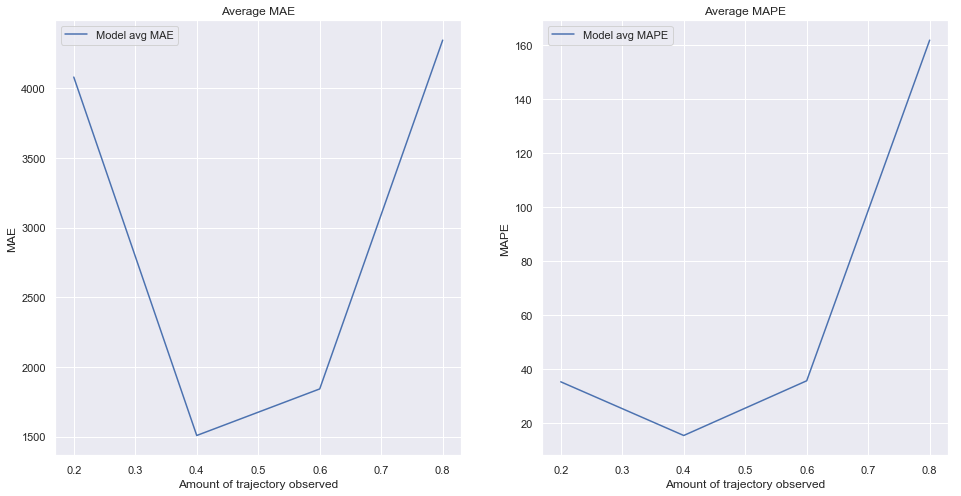

In [47]:
loaded = False
if loaded is False:
    test_trajs_pickle_path = '../data/test3.pkl'
    test_data = pd.read_pickle(test_trajs_pickle_path)
    n_test_trajs = list(test_data.traj.unique())
    n_test_trajs_to_use = 100 #len(n_trajs)
    test_trajs_to_use = frozenset(np.random.choice(n_test_trajs, size=n_test_trajs_to_use, replace=False))
    test_trajs = test_data[test_data.traj.transform(lambda j: j in test_trajs_to_use)]
    test_traj_ns = test_trajs.traj.unique()
    loaded=True

def load_test_seg(traj_n, seg_n):
    return test_trajs[(test_trajs.traj == traj_n) & (test_trajs.seg == seg_n)]

#fig, ax = plot_grid(1, 1)
out_of_sample_test_segs = {
    traj_n: pre_process(
        load_test_seg(traj_n, seg_n), 
        stop_compress_delta,
        seg_normalisers[seg_n]
    ) for traj_n in test_traj_ns
}

evaluate(models_to_use, out_of_sample_test_segs, seg_sizes)

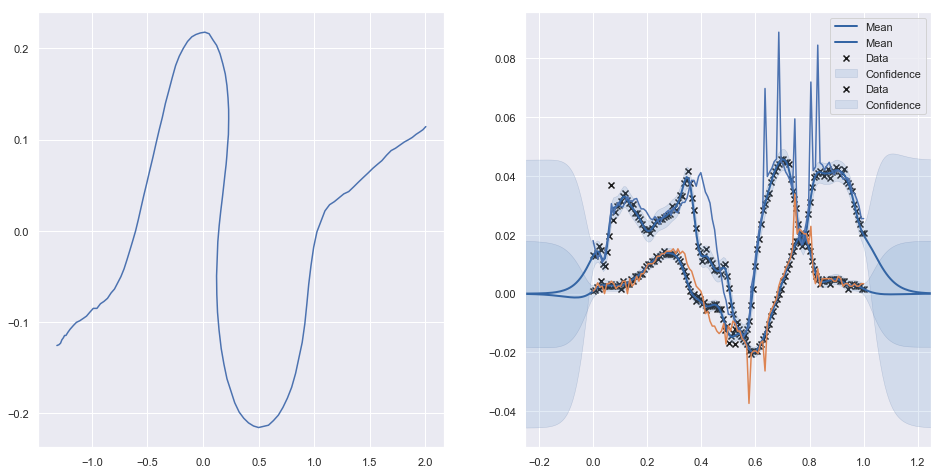

In [159]:
broken_seg_id = 461
broken_seg = test_trajs[(test_trajs.traj == brokken_seg_id) & (test_trajs.seg == seg_n)]
broken_seg = pre_process(broken_seg, stop_compress_delta)
_, ax = plot_grid(1, 2)
ax[0].plot(broken_seg.x, broken_seg.y)
plot_function(models_to_use[0].f_v_x, ax=ax[1])
plot_function(models_to_use[0].f_v_y, ax=ax[1])
ax[1].plot(broken_seg.tau, broken_seg.dx)
ax[1].plot(broken_seg.tau, broken_seg.dy)